In [74]:
import importlib
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import financial_data_structs as fds
# adding parent dir to path
sys.path.append(os.path.dirname(os.path.abspath('')))
import adv_fin_ml_func as fml

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 14.0)
importlib.reload(sys.modules['adv_fin_ml_func'])
importlib.reload(sys.modules['financial_data_structs'])

<module 'financial_data_structs' from '/mnt/c/Users/mlevy/Workspace/Advances-in-Financial-Machine-Learning/F-ML/data_analysis/financial_data_structs.py'>

### 3.1
On dollar bars, apply a symmetric CUSUM filter (where the threshold is the standard deviation of daily returns), add vertical bars, apply the triple-barrier method, and apply getBins to generate labels

In [32]:
out_fp = '../data/clean/IVE_tick.parq'
df = fds.parquet_to_df(out_fp)
df.head()

,price,bid,ask,volume,dollar_volume
timestamp,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00


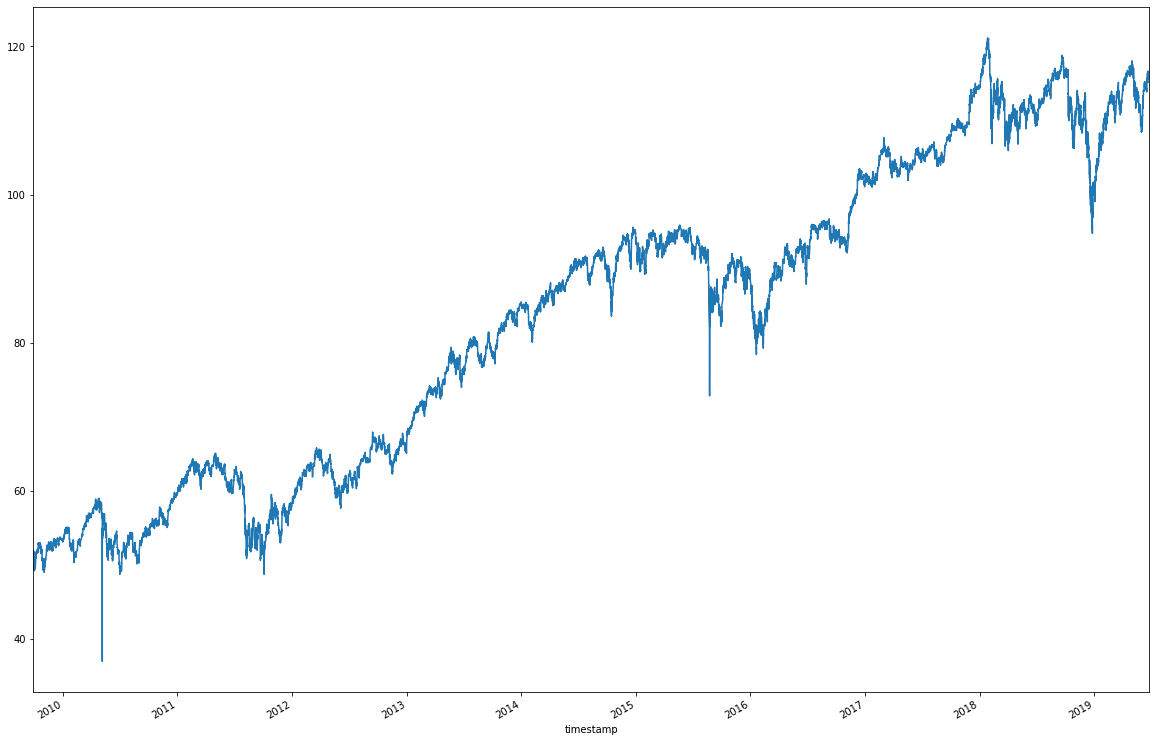

In [33]:
df_dol = fds.get_dollar_bars(df, 1_000_000)
df_dol.price.plot()

In [34]:
close = df_dol.price.copy()

# Remove duplicate indexes
close = close[~close.index.duplicated()]

In [35]:
# getting standard deviation of daily returns
dailyVol = fml.getDailyVol(close)

In [36]:
dailyVol

timestamp
2009-09-29 09:59:21         NaN
2009-09-29 10:04:46    0.005981
2009-09-29 10:31:39    0.004469
2009-09-29 10:52:23    0.004376
2009-09-29 11:34:53    0.004261
                         ...   
2019-06-25 15:26:58    0.004947
2019-06-25 15:45:56    0.004960
2019-06-25 15:50:57    0.004987
2019-06-25 15:55:00    0.005024
2019-06-25 15:59:23    0.005040
Name: price, Length: 58524, dtype: float64

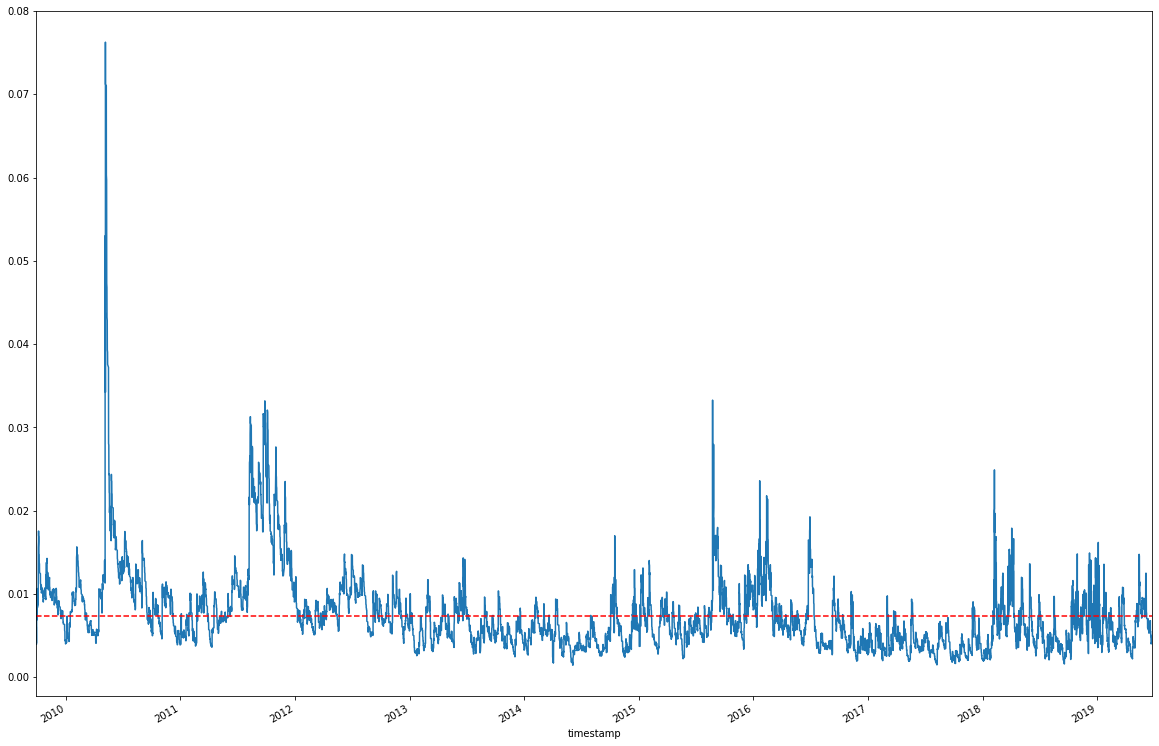

In [37]:
f, ax = plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(), ls='--', color='r')

In [38]:
# CUSUM Filter
tEvents = fml.getTEvents(np.log(close), h=dailyVol.mean())

In [39]:
tEvents

DatetimeIndex(['2009-09-28 12:33:18', '2009-09-29 09:27:39',
               '2009-09-29 12:00:17', '2009-09-30 09:44:47',
               '2009-09-30 09:56:31', '2009-09-30 12:48:14',
               '2009-09-30 15:05:38', '2009-10-01 09:52:26',
               '2009-10-01 11:16:04', '2009-10-01 15:51:53',
               ...
               '2019-06-06 15:35:14', '2019-06-07 11:17:10',
               '2019-06-10 09:46:45', '2019-06-12 10:18:41',
               '2019-06-17 09:57:13', '2019-06-18 09:39:43',
               '2019-06-20 09:30:00', '2019-06-20 12:20:48',
               '2019-06-20 15:50:44', '2019-06-25 09:42:50'],
              dtype='datetime64[ns]', length=3161, freq=None)

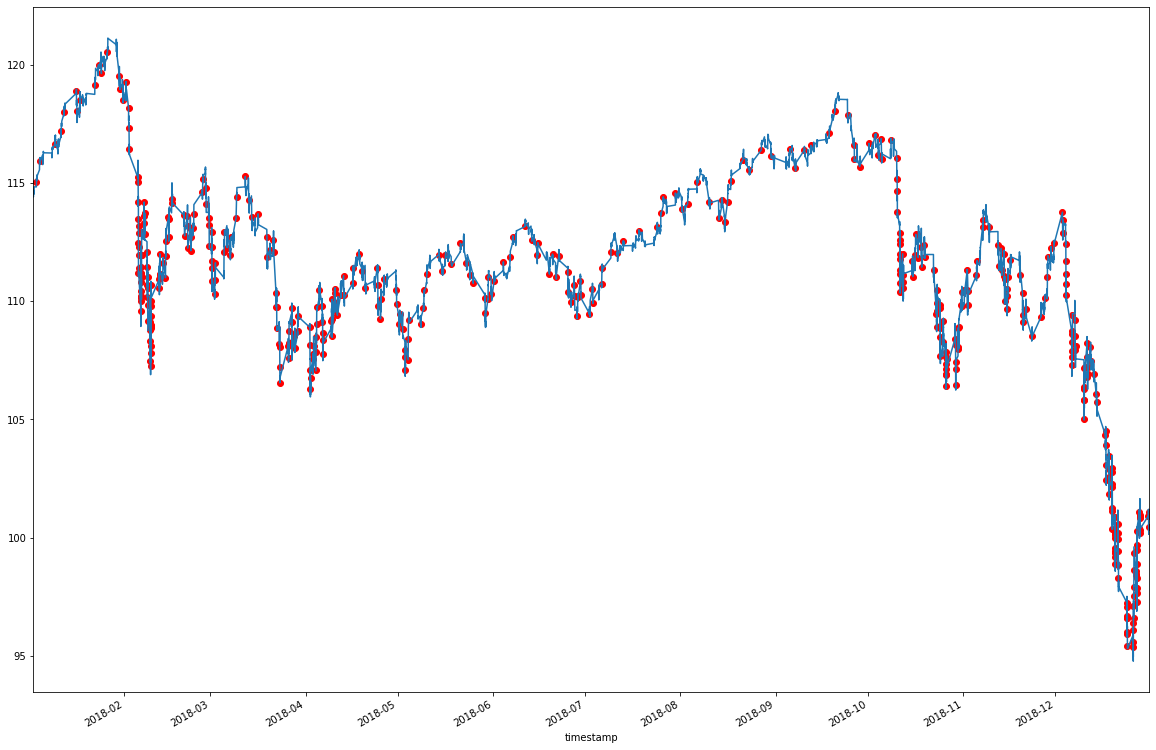

In [40]:
date = '2018'
f, ax = plt.subplots(figsize=(20,14))
close[date].plot(ax=ax)
plt.scatter(tEvents, close[date].reindex(tEvents),  c='r')

In [41]:
# Adding Vertical bars
# This is the expiration limit in our triple barrier method
t1 = fml.addVerticalBarrier(tEvents, close, numDays=1)

In [42]:
t1

2009-09-28 12:33:18   2009-09-29 12:34:54
2009-09-29 09:27:39   2009-09-30 09:32:03
2009-09-29 12:00:17   2009-09-30 12:48:14
2009-09-30 09:44:47   2009-10-01 09:52:26
2009-09-30 09:56:31   2009-10-01 10:00:15
                              ...        
2019-06-17 09:57:13   2019-06-18 10:02:18
2019-06-18 09:39:43   2019-06-19 09:57:29
2019-06-20 09:30:00   2019-06-21 09:30:00
2019-06-20 12:20:48   2019-06-21 12:28:50
2019-06-20 15:50:44   2019-06-21 15:59:41
Name: timestamp, Length: 3160, dtype: datetime64[ns]

In [43]:
# Applying triple-barrier method
minRet = 0.01
numThreads = 1
ptSl = [1, 1]
events = fml.getEvents(close, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1)

In [44]:
events

,t1,trgt
2009-10-02 09:32:42,2009-10-02 10:36:37,0.010414
2009-10-02 10:34:31,2009-10-05 09:35:27,0.010400
2009-10-05 12:55:39,2009-10-06 09:31:29,0.011719
2009-10-06 09:31:29,2009-10-07 09:47:25,0.016259
2009-10-06 11:16:28,2009-10-07 12:14:25,0.017185
2009-10-06 14:08:35,2009-10-07 14:12:08,0.017471
2009-10-07 11:04:15,2009-10-08 11:29:32,0.015954
2009-10-08 09:29:50,2009-10-09 09:41:48,0.014741
2009-10-12 09:43:45,2009-10-13 10:02:16,0.012437
2009-10-13 10:02:16,2009-10-14 09:34:13,0.011074


In [45]:
labels = fml.getBins(events, close)

In [46]:
labels

,ret,bin
2009-10-02 09:32:42,0.010761,1.0
2009-10-02 10:34:31,-0.000603,-1.0
2009-10-05 12:55:39,0.013530,1.0
2009-10-06 09:31:29,0.000982,1.0
2009-10-06 11:16:28,-0.006791,-1.0
2009-10-06 14:08:35,0.002930,1.0
2009-10-07 11:04:15,0.010517,1.0
2009-10-08 09:29:50,-0.003287,-1.0
2009-10-12 09:43:45,-0.009396,-1.0
2009-10-13 10:02:16,0.018579,1.0


In [47]:
labels.bin.value_counts()

 1.0    628
-1.0    457
Name: bin, dtype: int64

### 3.2
Drop rare labels

In [48]:
# This won't do anything since we only have two labels
filter_labels = fml.dropLabels(labels)
filter_labels.bin.value_counts()

 1.0    628
-1.0    457
Name: bin, dtype: int64

### 3.3
getBins_v2 created to return a 0 whenever the vertical barrier is the one touched first.

In [49]:
labels_v2 = fml.getBins_v2(events, close, t1)
labels_v2.bin.value_counts()

 0.0    729
-1.0    181
 1.0    175
Name: bin, dtype: int64

### 3.4
Utilize a trend-following strategy (e.g., crossing moving averages) on the price data. Then derive meta-labels for this strategy. Finally, train a random forest to decide whether to trade or not.

In [50]:
# short_window = 150
# long_window = 360
short_window = 30
long_window = 70
ma = fds.MovingAvgCross(close, long_window, short_window)
buy_signals = ma.buy_signal()
sell_signals = ma.sell_signal()

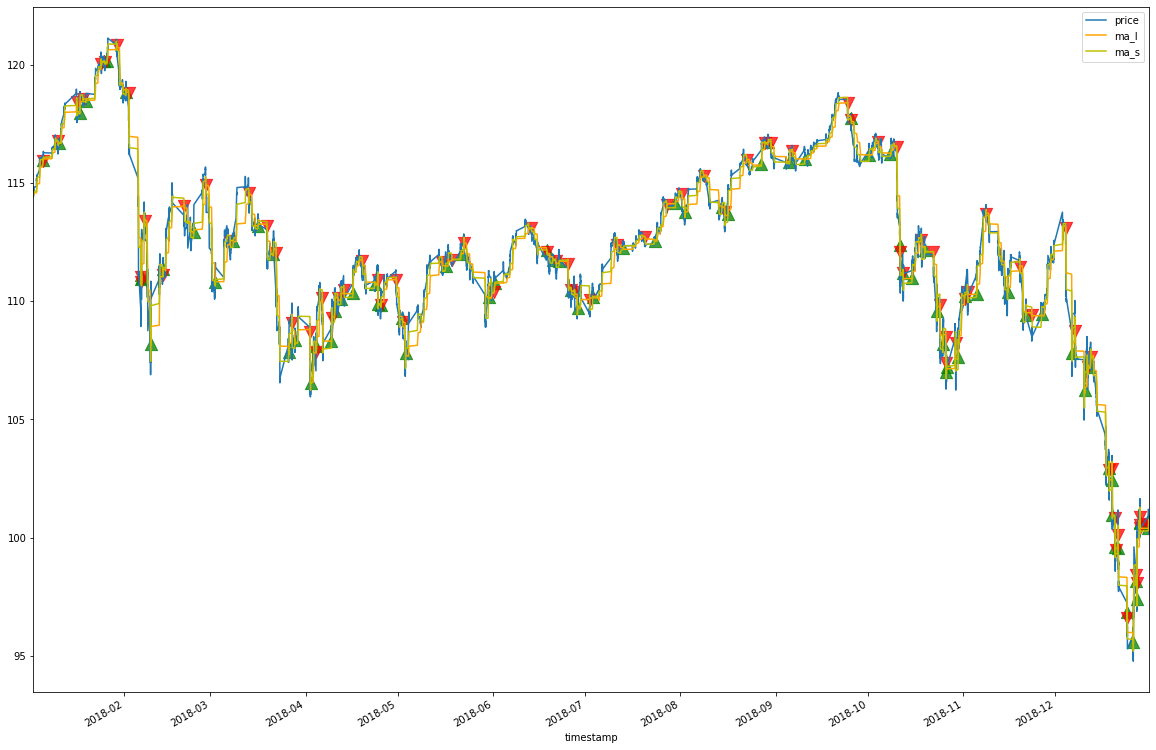

In [72]:
date = '2018'
ma.ma_df[date].plot(color=[None, 'orange', 'y'])
plt.scatter(buy_signals[date].index, buy_signals[date], c='g', marker='^', s=150, alpha=.75)
plt.scatter(sell_signals[date].index, sell_signals[date], c='r', marker='v', s=150, alpha=.75)

In [120]:
long = pd.Series(1, index=buy_signals.index)
short = pd.Series(-1, index=sell_signals.index)
ma_side = pd.concat([long, short]).sort_index()  # each time we switch sides

In [121]:
# getting standard deviation of daily returns
dailyVol = fml.getDailyVol(close)

# CUSUM Filter
# tEvents = fml.getTEvents(np.log(close), h=dailyVol.mean())
tEvents = fml.getTEvents(close, h=dailyVol.mean())

# Adding Vertical bars
# This is the expiration limit in our triple barrier method
t1 = fml.addVerticalBarrier(tEvents, close, numDays=1)

# Applying triple-barrier method
minRet = 0.01
numThreads = 1
ptSl = [1, 2]
events = fml.getEvents(close, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1, side=ma_side).dropna()
events.side.value_counts()

 1.0    77
-1.0    10
Name: side, dtype: int64

In [122]:
labels = fml.getBins_v2(events, close, t1).dropna()
labels.bin.value_counts()

1.0    64
0.0    23
Name: bin, dtype: int64

In [123]:
features = pd.DataFrame().assign(vol=events.trgt).assign(side=events.side).drop_duplicates().dropna()

In [124]:
X = features.values
y = labels.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [125]:
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=123)

In [126]:
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6896551724137931


### 3.5
Develop a mean-reverting strategy based on Bollinger bands. Derive meta-labels, train a random forest to decide whether to trade or not, and determine:  
  - What is the accuracy of predictions from the primary model? What are the precision, recall, and F1-scores?  
  - What is the accuracy of predictions from the secondary model? What are the precision, recall, and F1-scores?

In [127]:
window = 1000
num_std = 2
bol = fds.BollingerBands(close, window, num_std)
buy_signals = bol.buy_signal()
sell_signals = bol.sell_signal()

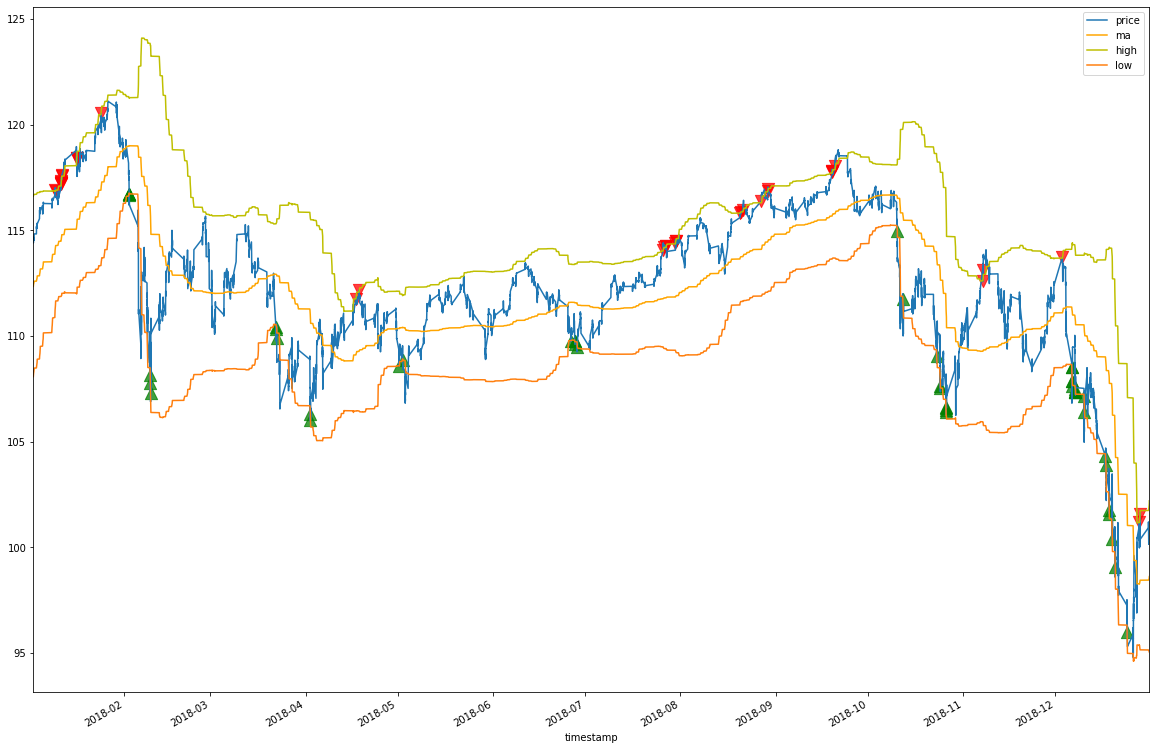

In [128]:
date = '2018'
bol.bol_df[date].plot(color=[None, 'orange', 'y'])
plt.scatter(buy_signals[date].index, buy_signals[date], c='g', marker='^', s=150, alpha=.75)
plt.scatter(sell_signals[date].index, sell_signals[date], c='r', marker='v', s=150, alpha=.75)

In [129]:
long = pd.Series(1, index=buy_signals.index)
short = pd.Series(-1, index=sell_signals.index)
bol_side = pd.concat([long, short]).sort_index()  # each time we switch sides

In [130]:
# getting standard deviation of daily returns
dailyVol = fml.getDailyVol(close)

# CUSUM Filter
# tEvents = fml.getTEvents(np.log(close), h=dailyVol.mean())
tEvents = fml.getTEvents(close, h=dailyVol.mean())

# Adding Vertical bars
# This is the expiration limit in our triple barrier method
t1 = fml.addVerticalBarrier(tEvents, close, numDays=1)

# Applying triple-barrier method
minRet = 0.01
numThreads = 1
ptSl = [0, 2]
events = fml.getEvents(close, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1, side=bol_side).dropna()
events.side.value_counts()

 1.0    77
-1.0    10
Name: side, dtype: int64

In [131]:
labels = fml.getBins_v2(events, close, t1).dropna()
labels.bin.value_counts()

1.0    64
0.0    23
Name: bin, dtype: int64

In [132]:
# Getting serial correlation as an additional feature
returns = pd.Series(np.diff(np.log(close)), index=close.index[1:])
scorr = returns.rolling(window=window).corr(returns.shift(1)).dropna().rename('autocorr')

In [133]:
features = pd.DataFrame().assign(vol=events.trgt).assign(ma_side=ma_side).assign(scorr=scorr).drop_duplicates().dropna()

In [134]:
X = features.values
y = labels.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [135]:
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=123)

In [136]:
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6896551724137931
